# US Coronavirus Data Exploration

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

Get most recent population data (source may need to be updated if more recent estimates are available, currently estimated for April-June 2019)

In [16]:
# Download the population dataset
pop_data = pd.read_excel('https://www2.census.gov/programs-surveys/popest/tables/2010-2019/counties/totals/co-est2019-annres.xlsx')

# Set new dataframe to pertinent information and rename columns
population = pd.DataFrame(pop_data.iloc[4:,0:2]).dropna()
cols = list(population.columns)
rename_cols = {}
for i, col in enumerate(cols):
    rename_cols[col] = i
population.rename(rename_cols, axis=1, inplace=True)
population.rename({0: 'county', 1: 'population'}, axis=1, inplace=True)

# Parse weird location column into clean columns that can be aggregated or grouped
population['state'] = population.county.str.extract(r',\s+([A-Z]\w+)')
population['county'] = population.county.str.replace(r',\s+([A-Z]\w+)', '', regex=True).replace(r'\s+County','',regex=True).str.slice(start=1)
population['country'] = 'United States'

# Preview DataFrame
population.reset_index().drop('index', axis=1)

,county,population,state,country
0,Autauga,54571,Alabama,United States
1,Baldwin,182265,Alabama,United States
2,Barbour,27457,Alabama,United States
3,Bibb,22915,Alabama,United States
4,Blount,57322,Alabama,United States
...,...,...,...,...
3137,Sweetwater,43806,Wyoming,United States
3138,Teton,21294,Wyoming,United States
3139,Uinta,21118,Wyoming,United States
3140,Washakie,8533,Wyoming,United States


In [11]:
pop_data.head(10)

,table with row headers in column A and column headers in rows 3 through 4 (leading dots indicate sub-parts),Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,Annual Estimates of the Resident Population fo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Geographic Area,2010-04-01 00:00:00,NaN,Population Estimate (as of July 1),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Census,Estimates Base,2010,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0
3,United States,308745538,308758105,309321666,311556874.0,313830990.0,315993715.0,318301008.0,320635163.0,322941311.0,324985539.0,326687501.0,328239523.0
4,".Autauga County, Alabama",54571,54597,54773,55227.0,54954.0,54727.0,54893.0,54864.0,55243.0,55390.0,55533.0,55869.0
5,".Baldwin County, Alabama",182265,182265,183112,186558.0,190145.0,194885.0,199183.0,202939.0,207601.0,212521.0,217855.0,223234.0
6,".Barbour County, Alabama",27457,27455,27327,27341.0,27169.0,26937.0,26755.0,26283.0,25806.0,25157.0,24872.0,24686.0
7,".Bibb County, Alabama",22915,22915,22870,22745.0,22667.0,22521.0,22553.0,22566.0,22586.0,22550.0,22367.0,22394.0
8,".Blount County, Alabama",57322,57322,57376,57560.0,57580.0,57619.0,57526.0,57526.0,57494.0,57787.0,57771.0,57826.0
9,".Bullock County, Alabama",10914,10911,10876,10675.0,10606.0,10549.0,10663.0,10400.0,10389.0,10176.0,10174.0,10101.0


Get most recent coronavirus data

In [5]:
covid = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv', error_bad_lines=False)
covid['date'] = pd.to_datetime(covid['date'])
covid

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0
...,...,...,...,...,...,...
15831,2020-03-27,Park,Wyoming,56029.0,1,0
15832,2020-03-27,Sheridan,Wyoming,56033.0,5,0
15833,2020-03-27,Sweetwater,Wyoming,56037.0,1,0
15834,2020-03-27,Teton,Wyoming,56039.0,12,0


In [28]:
# Define a function that will get aggregated visual statistics for any location over time (Uses locations dataset, may need to input if not consistent with global definition)
def get_stats(data, state=None, county=None, population=population):
    data.date = pd.to_datetime(data.date)
    if state:
        if county:
            locale = data.loc[(data.state == state) & (data.county == county)]
            locale['population'] = population.loc[(population.state == state) * (population.county == county)]['population'].sum()
            location = county
        else:
            locale = data.loc[data.state == state]
            locale['population'] = population.loc[population.state == state]['population'].sum()
            location = state
    elif county:
        print('If specifying county, it is wise to clarify which state you are looking for as well, as several states have identically named counties')
        locale = data.loc[data.county == county]
        locale['population'] = population.loc[population.county == county]['population'].sum()
        location = county
    else:
        locale = data.copy()
        locale['population'] = population['population'].sum()
        location = 'US'

    # Group by date to aggregate across locale
    locale = locale.groupby(by='date').sum().reset_index()
    # Create a copy of the data, and increase the date by one day so each row show's the data for the previous date.
    locale_b4 = locale.copy()
    locale_b4.date = locale_b4.date + pd.to_timedelta('1 days')

    # Rename yesterday's columns to have a '-1' in it
    rename_cols = {col: f'{col}-1' for col in locale_b4.columns.drop('date')}
    locale_b4.rename(rename_cols, axis=1, inplace=True)

    # Merge yesterday's data with todays'
    locale = locale_b4.merge(right=locale, on='date')

    # Create colums for today's cases and deaths
    locale['cases_today'] = locale.cases - locale['cases-1']
    locale['deaths_today'] = locale.deaths - locale['deaths-1']

    # Create columns for per-capita cases and deaths
    locale['cases_percapita'] = locale.cases / locale.population *100
    locale['deaths_percapita'] = locale.deaths / locale.population *100

    # Initialize the subplot numbers
    spx = 3
    spy = 3
    spi = 1

    # Create a figure with a given size
    plt.figure(figsize=(30,22))

    # Plot the cummulative cases and deaths over time for the locale
    # plt.subplot(spy,spx,spi)
    # chart = sns.lineplot(x=locale.date, y=locale.cases, color='#4499ee')
    # chart = sns.lineplot(x=locale.date, y=locale.cases_today, color='#999999')
    # chart.set_xticklabels(labels=locale.date.dt.date, rotation=90)
    # plt.title(f'{location} Cummulative Cases')
    # spi += 1

    plt.subplot(spy,spx,spi)
    chart = sns.barplot(x=locale.date, y=locale.cases, color='#4499ee')
    chart = sns.barplot(x=locale.date, y=locale.cases_today, color='#999999')
    chart.set_xticklabels(labels=locale.date.dt.date, rotation=90)
    plt.title(f'{location} Cummulative Cases')
    spi += 1

    plt.subplot(spy,spx,spi)
    chart = sns.barplot(x=locale.date, y=locale.deaths, color='#ee4444')
    chart = sns.barplot(x=locale.date, y=locale.deaths_today, color='#999999')
    chart.set_xticklabels(labels=locale.date.dt.date, rotation=90)
    plt.title(f'{location} Cummulative Deaths')
    spi += 1

    plt.subplot(spy,spx,spi)
    chart = sns.barplot(x=locale.date, y=locale.cases, color='#4499ee')
    chart = sns.barplot(x=locale.date, y=locale.deaths, color='#ee4444')
    chart.set_xticklabels(labels=locale.date.dt.date, rotation=90)
    plt.title(f'{location} Cumulative Cases & Deaths')
    spi += 1

    # Plot the daily cases and deaths over time for the locale
    plt.subplot(spy,spx,spi)
    chart = sns.barplot(x=locale.date, y=locale.cases_today, color='#4499ee')
    chart.set_xticklabels(labels=locale.date.dt.date, rotation=90)
    plt.title(f'{location} Daily Cases')
    spi += 1

    plt.subplot(spy,spx,spi)
    chart = sns.barplot(x=locale.date, y=locale.deaths_today, color='#ee4444')
    chart.set_xticklabels(labels=locale.date.dt.date, rotation=90)
    plt.title(f'{location} Daily Deaths')
    spi += 1

    plt.subplot(spy,spx,spi)
    chart = sns.barplot(x=locale.date, y=locale.cases_today, color='#4499ee')
    chart = sns.barplot(x=locale.date, y=locale.deaths_today, color='#ee4444')
    chart.set_xticklabels(labels=locale.date.dt.date, rotation=90)
    plt.title(f'{location} Daily Cases & Deaths')
    spi += 1

    # Plot the per-capita cases and deaths over time for the locale

    plt.subplot(spy,spx,spi)
    chart = sns.barplot(x=locale.date, y=locale.cases_percapita, color='#4499ee')
    chart.set_xticklabels(labels=locale.date.dt.date, rotation=90)
    plt.title(f'{location} Cases Per-Capita')
    spi += 1

    plt.subplot(spy,spx,spi)
    chart = sns.barplot(x=locale.date, y=locale.deaths_percapita, color='#ee4444')
    chart.set_xticklabels(labels=locale.date.dt.date, rotation=90)
    plt.title(f'{location} Deaths Per-Capita')
    spi += 1

    plt.subplot(spy,spx,spi)
    chart = sns.barplot(x=locale.date, y=locale.cases_percapita, color='#4499ee')
    chart = sns.barplot(x=locale.date, y=locale.deaths_percapita, color='#ee4444')
    chart.set_xticklabels(labels=locale.date.dt.date, rotation=90)
    plt.title(f'{location} Cases & Deaths Per-Capita')

    plt.tight_layout()
    plt.show()

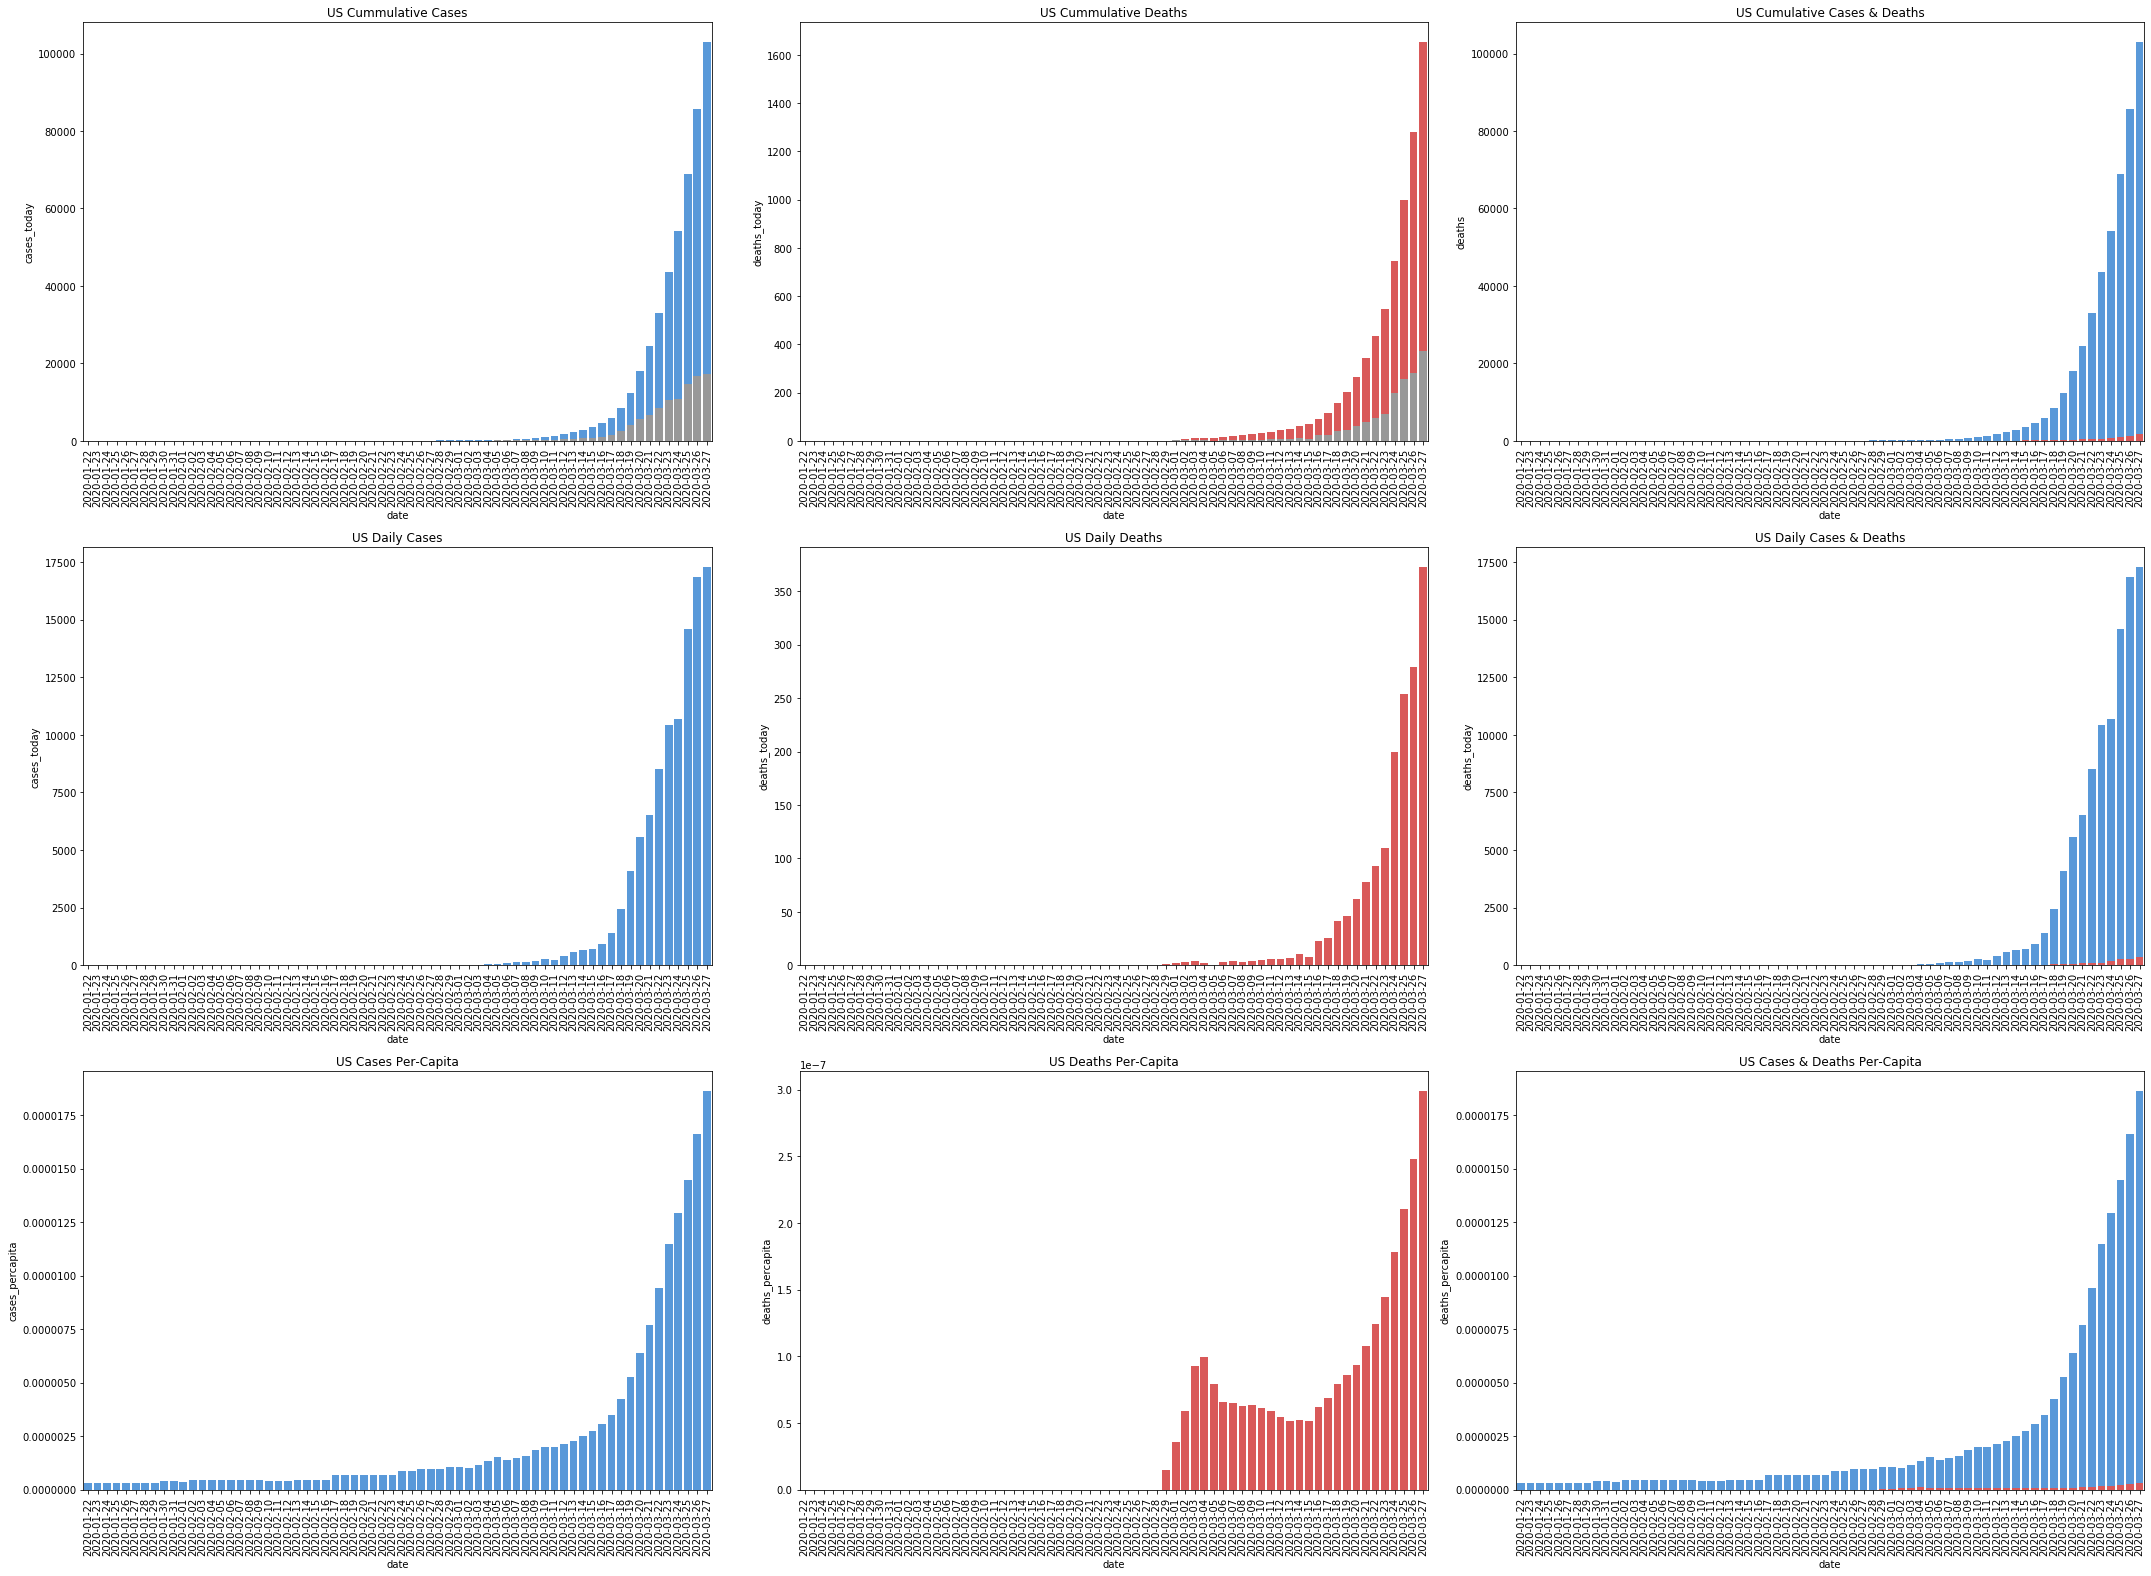

In [29]:
# Show the statistics for the US
get_stats(covid)

# Try it yourself! 
Write `get_stats(covid, state='Your State', county='Your County')` and see what kind of statistics you can find for your county! (Or any county for that matter)

P.S. If you want to see something really scary, check out county=`'New York City', State='New York'`

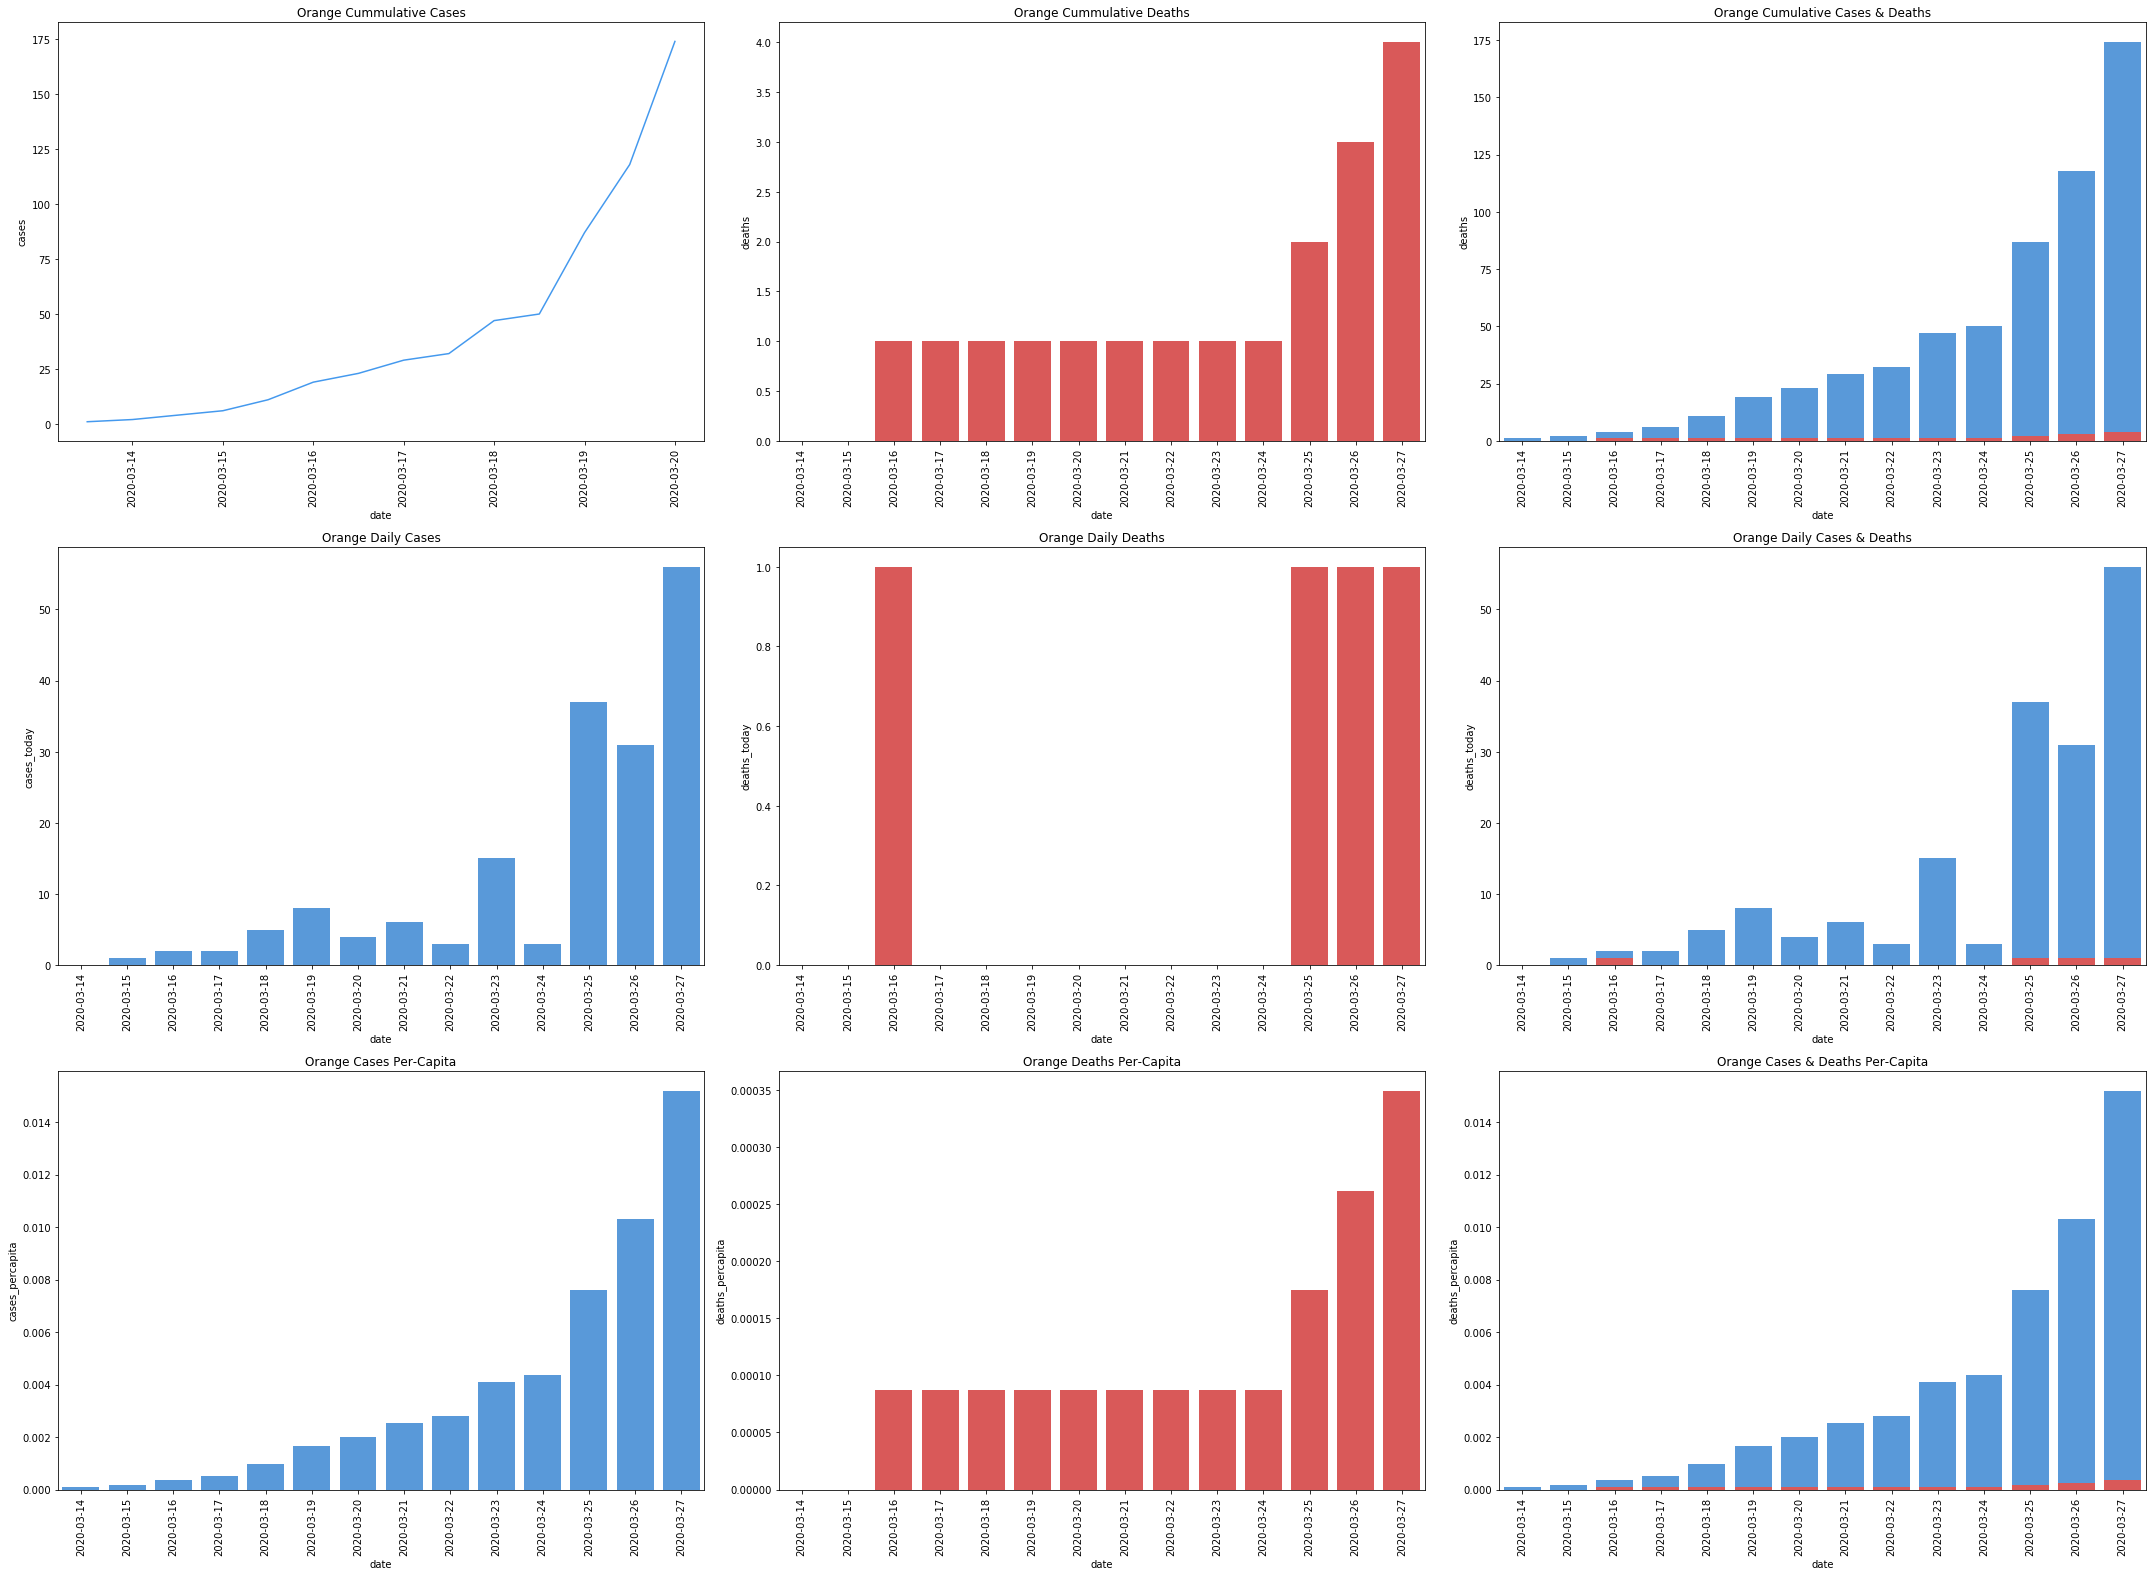

In [21]:
get_stats(covid, state='Florida', county='Orange')

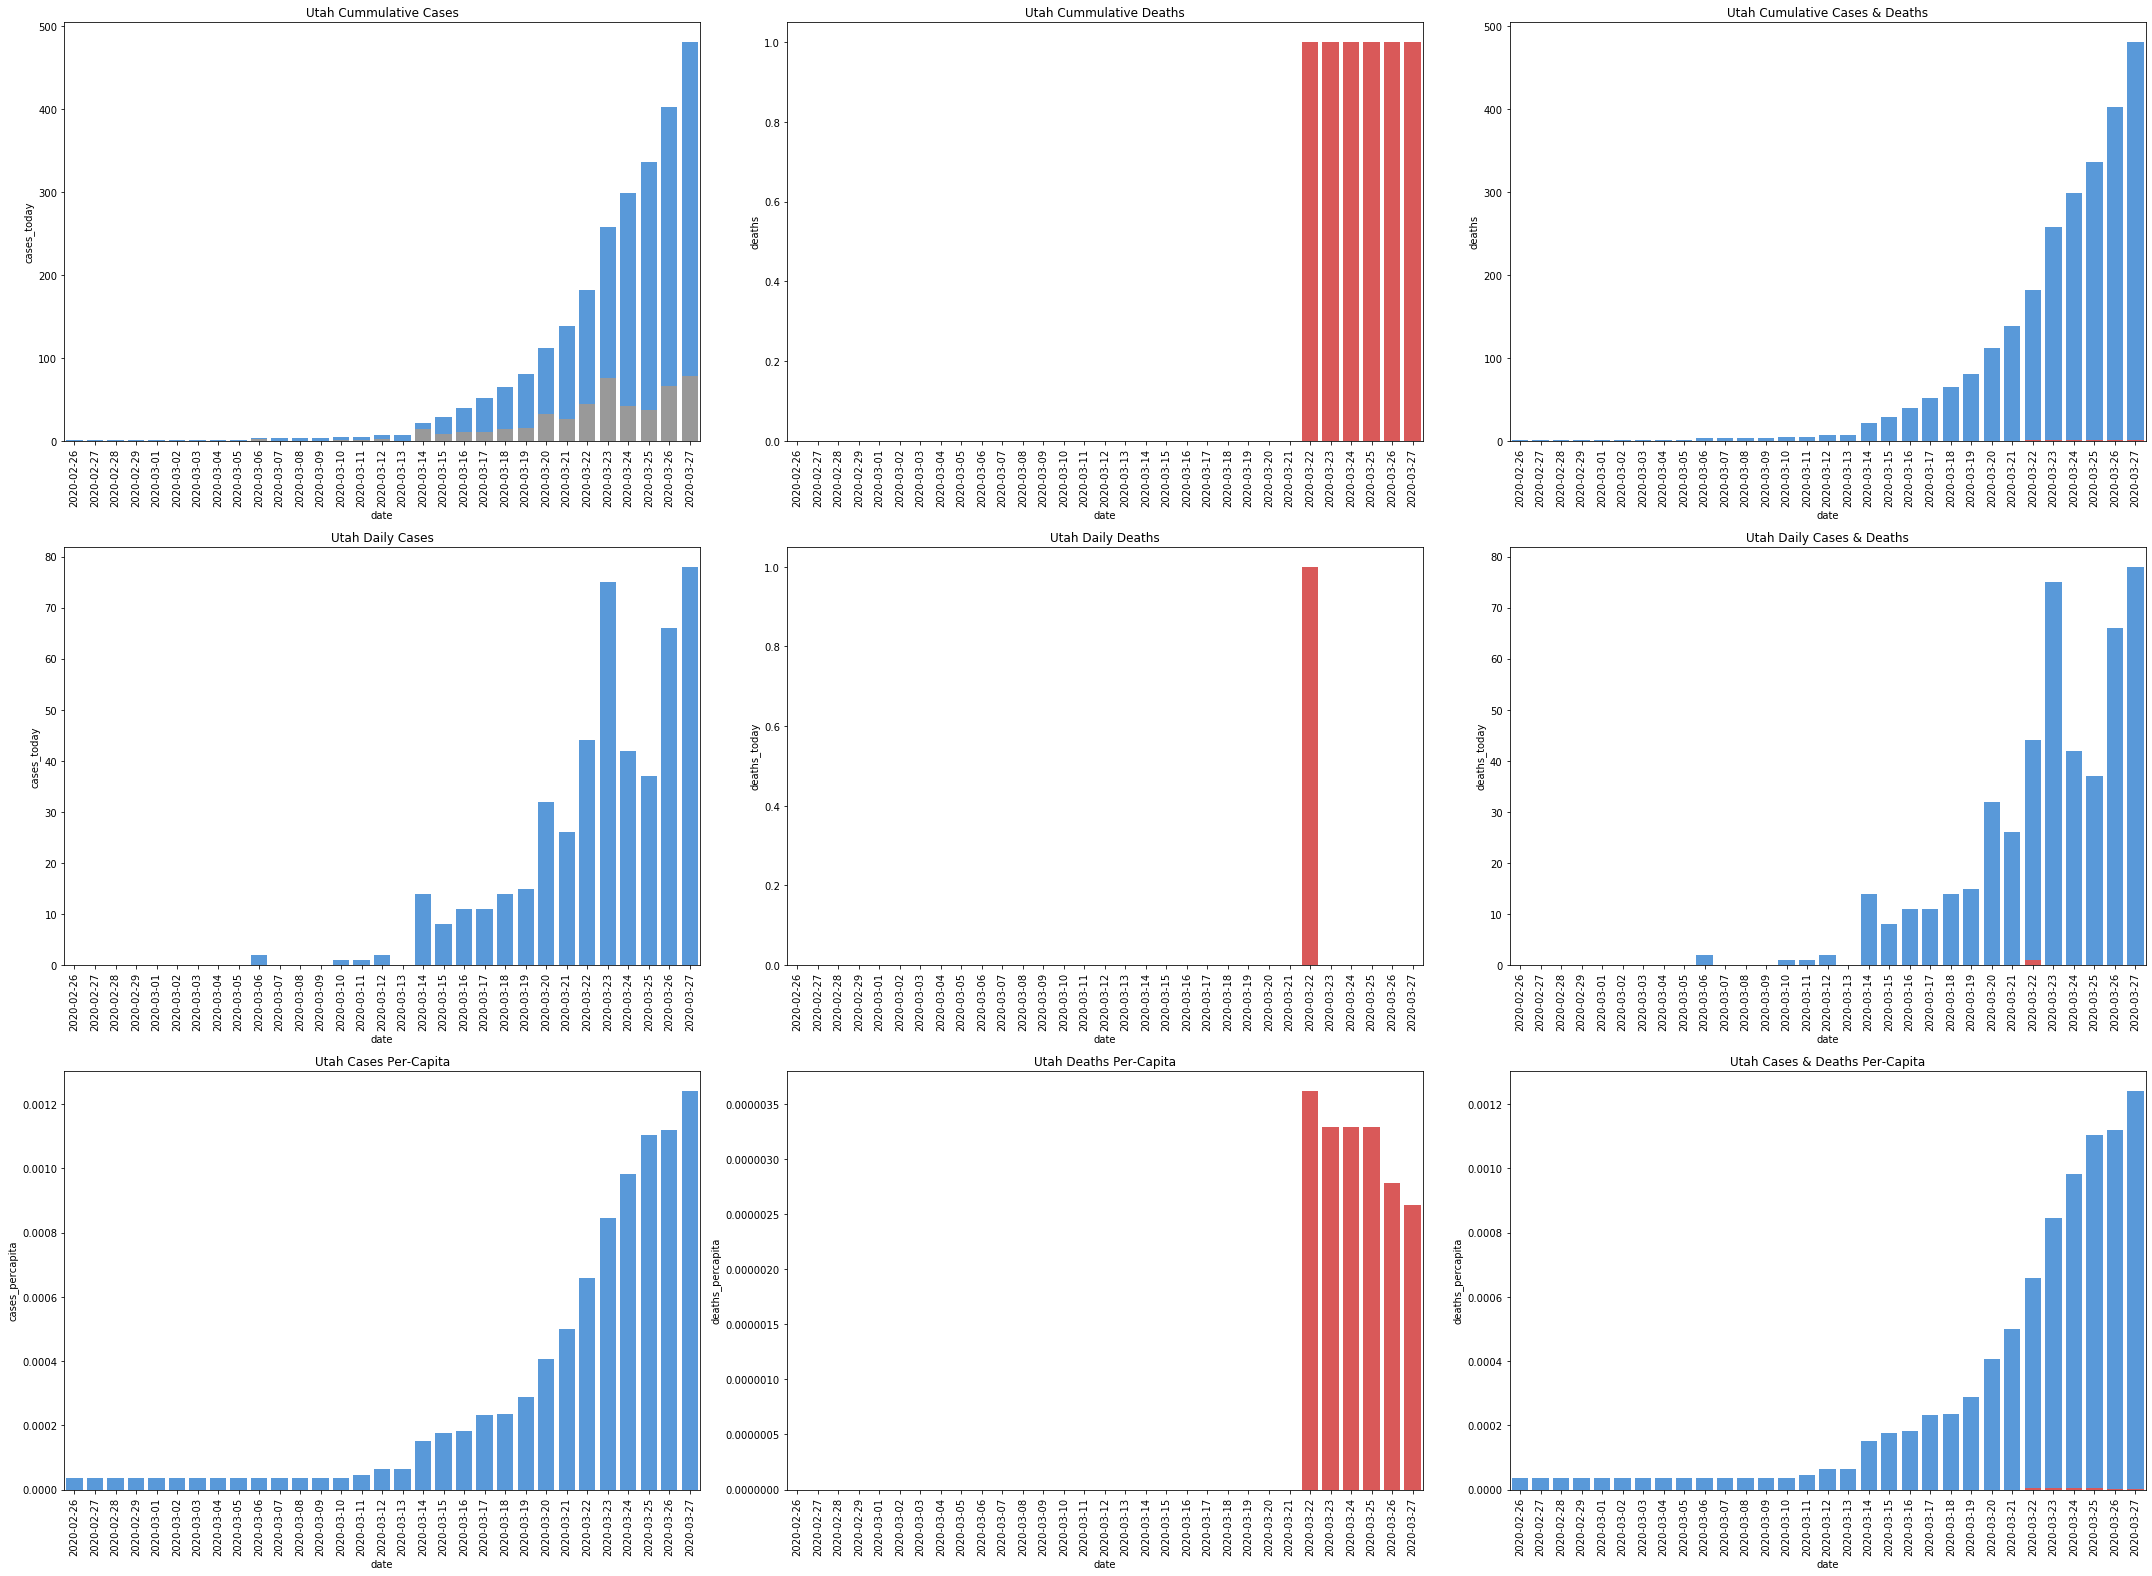

In [27]:
get_stats(covid, state='Utah')
